In [9]:
import numpy as np
import tqdm
import matplotlib.pyplot as plt
from corner import corner

import os
os.environ["JAX_ENABLE_X64"] = "True"
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["XLA_FLAGS"] = (
    os.environ.get("XLA_FLAGS", "")
    + " --xla_cpu_multi_thread_eigen=false intra_op_parallelism_threads=1"
)

import jax
jax.config.update('jax_enable_x64', True)
import jax.numpy as jnp
import numpyro
numpyro.set_platform('gpu')
import tinygp

In [2]:
jax.devices()

[CudaDevice(id=0), CudaDevice(id=1)]

In [3]:
true = numpyro.distributions.Normal()
N = 100

In [4]:
x = true.sample(jax.random.PRNGKey(0), (N,))

2024-09-05 13:10:51.028713: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version (12.5.82). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


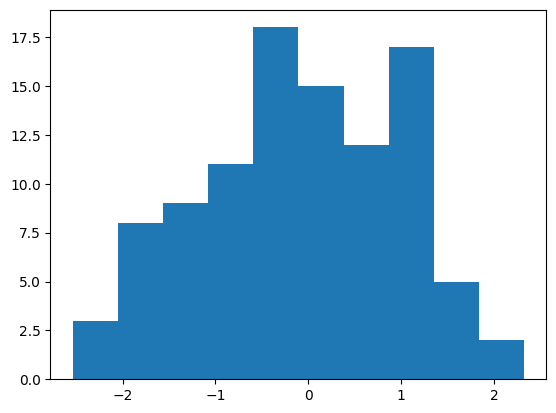

In [5]:
plt.hist(x);

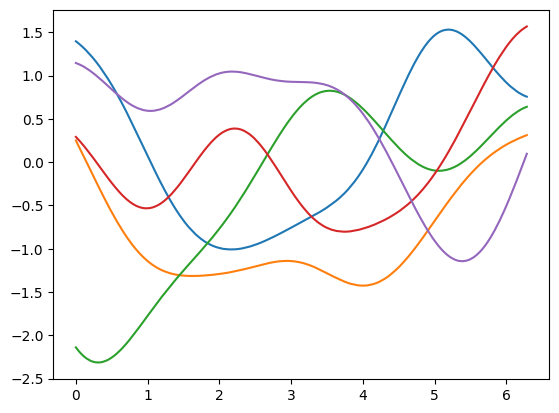

In [6]:
xx = jnp.linspace(0, 2 * np.pi, 1_000)
kernel = tinygp.kernels.ExpSquared(scale = 1)
gp = tinygp.GaussianProcess(kernel, xx)
yy = gp.sample(jax.random.PRNGKey(0), shape = (5,))
plt.plot(xx, yy.T);

In [10]:
xx = jnp.linspace(-3, 3, 100)

In [14]:
def model():
    mean = numpyro.sample(
        'loc',
        # numpyro.distributions.Uniform(-3, 3),
        numpyro.distributions.Normal(N, 1),
    )
    scale = numpyro.sample(
        'scale',
        # numpyro.distributions.Uniform(0, 2),
        numpyro.distributions.HalfNormal(),
    )
    sigma = numpyro.sample(
        'length',
        # numpyro.distributions.Uniform(0, 2),
        numpyro.distributions.HalfNormal(),
    )
    kernel = sigma**2 * tinygp.kernels.ExpSquared(scale)
    # kernel = sigma * tinygp.kernels.Matern52(scale)
    kernel = tinygp.kernels.quasisep.Matern52(scale, sigma)
    gp = tinygp.GaussianProcess(kernel, xx, mean = mean, diag = 1e-6)
    _log_rates = numpyro.sample('log_rates', gp.numpyro_dist())
    log_rates = jnp.interp(x, xx, _log_rates)
    Nexp = numpyro.deterministic('Nexp', jnp.trapezoid(jnp.exp(_log_rates), xx))
    numpyro.factor('log_lkl', log_rates.sum())
    numpyro.factor('log_poiss', -Nexp)
    # numpyro.sample('_Nexp', numpyro.distributions.Poisson(Nexp), obs = N)

In [15]:
nuts = numpyro.infer.NUTS(model) #, max_tree_depth = 5)
mcmc = numpyro.infer.MCMC(nuts, num_warmup = 1_000, num_samples = 1_000)
mcmc.run(jax.random.PRNGKey(1))
mcmc.print_summary()

warmup:   2%|      | 30/2000 [01:43<4:08:12,  7.56s/it, 1023 steps of size 6.29e-03. acc. prob=0.71]E0905 13:13:36.149658  547679 pjrt_stream_executor_client.cc:3067] Execution of replica 0 failed: INTERNAL: CustomCall failed: CpuCallback error: Traceback (most recent call last):
  File "/work/submit/mmould/miniforge3/envs/gpu/lib/python3.10/runpy.py", line 196, in _run_module_as_main
  File "/work/submit/mmould/miniforge3/envs/gpu/lib/python3.10/runpy.py", line 86, in _run_code
  File "/work/submit/mmould/miniforge3/envs/gpu/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
  File "/work/submit/mmould/miniforge3/envs/gpu/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance
  File "/work/submit/mmould/miniforge3/envs/gpu/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start
  File "/work/submit/mmould/miniforge3/envs/gpu/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start
  File

In [ ]:
posterior = mcmc.get_samples()
log_rates = posterior.pop('log_rates')

In [ ]:
corner(
    np.transpose(list(posterior.values())),
    labels = list(posterior.keys()),
    truths = [N, None, None, None],
);

In [ ]:
plt.plot(xx, jnp.exp(true.log_prob(xx)) * N)
h, b = np.histogram(x, density = True)
plt.stairs(h * N, b)
plt.scatter(x, jnp.ones_like(x), s = 1)
plt.plot(xx, np.quantile(jnp.exp(log_rates), (0.05, 0.5, 0.95), axis = 0).T);